In [ ]:
#for colab
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install imblearn
!pip install transformers[torch]
!pip install pynvml

In [3]:
import pandas as pd
import numpy as np
import os, sys
import warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from datasets import Dataset, Features, ClassLabel,load_dataset,Value,interleave_datasets
import matplotlib.pyplot as plt
# for colab gpu memory
#from pynvml import *

sys.path.append(os.path.abspath(os.path.join('Dataset')))
warnings.filterwarnings('ignore')
path = 'Dataset/'


In [4]:
# mount google drive location
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/'


Mounted at /content/drive


In [ ]:
#check allocate gpu memory in colab
# def print_gpu_utilization():
#     nvmlInit()
#     handle = nvmlDeviceGetHandleByIndex(0)
#     info = nvmlDeviceGetMemoryInfo(handle)
#     print(f"GPU memory occupied: {info.used//1024**2} MB.")


# def print_summary(result):
#     print(f"Time: {result.metrics['train_runtime']:.2f}")
#     print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
#     print_gpu_utilization()

### Importing the dataset

In [5]:
df = pd.read_csv(path+'ToS-100.csv',header=0,encoding='utf-8')
# A, CH, CR, J, LAW, LTD, PINC, TER, USE
data = df[['text', 'label', 'A', 'CH', 'CR', 'J', 'LAW', 'LTD', 'PINC', 'TER', 'USE']]
data

,text,label,A,CH,CR,J,LAW,LTD,PINC,TER,USE
0,websites & communications terms of use,0,0,0,0,0,0,0,0,0,0
1,please read the terms of this entire document ...,0,0,0,0,0,0,0,0,0,0
2,by accessing or signing up to receive communic...,1,0,0,0,0,0,0,0,0,1
3,our websites include multiple domains such as ...,0,0,0,0,0,0,0,0,0,0
4,you may also recognize our websites by nicknam...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20412,you may terminate your account at our service ...,0,0,0,0,0,0,0,0,0,0
20413,the following provisions shall survive termina...,0,0,0,0,0,0,0,0,0,0
20414,"the company reserves the right , at its sole d...",1,0,1,0,0,0,0,0,0,0
20415,"your continued use of the service , following ...",1,0,0,0,0,0,0,0,0,1


In [6]:
#sum of each category
data.sum(axis=0)

text     websites & communications terms of useplease r...
label                                                 2182
A                                                      106
CH                                                     344
CR                                                     216
J                                                      136
LAW                                                    148
LTD                                                    626
PINC                                                   102
TER                                                    420
USE                                                    296
dtype: object

# Class Labelling

To reduce the class imbalancing, We will reduce number of classes by grouping them together

Column: (original columns) description

FAIR (label) the sentence does not have any unfair clauses

UNBALANCED_DELECRATION (ltd + a) liability exclusions and limitations, arbitration on disputes arising from the contract

REMOVE_CONTENT: (cr) the provider’s right to unilaterally remove consumer content from the service, including in-app purchases

TERMINATE_CONTRACT: (ter + ch) the provider’s right to unilaterally terminate or modify the contract and/or the service

OTHER (j + law + use + pinc) other reasons

In [8]:
data['TERMINATE_CONTRACT'] = [1 if (x['TER'] == 1 or x['CH'] == 1) else 0 for index, x in data.iterrows()]
data['FAIR'] = [1 if x['label'] == 0 else 0 for index, x in data.iterrows()]
data['REMOVE_CONTENT'] = [1 if x['CR'] == 1 else 0 for index, x in data.iterrows()]
data['UNBALANCED_DELECRATION'] = [1 if (x['LTD'] == 1 or x['A'] == 1) else 0 for index, x in data.iterrows()]
data['OTHER'] = [1 if (x['TERMINATE_CONTRACT'] == 0 and x['FAIR'] == 0 and x['REMOVE_CONTENT'] == 0 and x['UNBALANCED_DELECRATION']  == 0) else 0 for index, x in data.iterrows()]

In [9]:
class_name = ['FAIR','REMOVE_CONTENT','UNBALANCED_DELECRATION','TERMINATE_CONTRACT','OTHER']

In [10]:
class_sample_count = data[class_name].sum(axis=0).sort_values(ascending=True)
class_sample_count

REMOVE_CONTENT              216
OTHER                       608
TERMINATE_CONTRACT          717
UNBALANCED_DELECRATION      732
FAIR                      18235
dtype: int64

In [11]:
cleaned_df = data[['text','FAIR','REMOVE_CONTENT','UNBALANCED_DELECRATION','TERMINATE_CONTRACT','OTHER']]
cleaned_df[class_name].sum(axis=1).value_counts()

1    20328
2       87
3        2
dtype: int64

There are 89 samples has more than 1 class label, we will assign it to one of its class with least total number of samples to reduce class imbalancing.

In [12]:
for index, row in cleaned_df.iterrows():
    if row[class_name].sum() > 1:
        tem = True
        for classes in class_sample_count.index.to_list():
            if row[classes] == 1 and tem:
                tem = False
                #set other class to 0
                for other_classes in class_sample_count.index.to_list():
                    if other_classes != classes:
                        cleaned_df.loc[index, other_classes] = 0
cleaned_df[class_name].sum(axis=1).value_counts()

1    20417
dtype: int64

In [13]:
cleaned_df[class_name].sum(axis=0).sort_values(ascending=True)

REMOVE_CONTENT              216
OTHER                       608
TERMINATE_CONTRACT          653
UNBALANCED_DELECRATION      705
FAIR                      18235
dtype: int64

we also need to convert the class into one columns with 5 values as label

In [14]:
cleaned_df['label'] = 0
for index, row in cleaned_df.iterrows():
    if row.FAIR != 1:
        argmax = np.argmax(row[['REMOVE_CONTENT','UNBALANCED_DELECRATION','TERMINATE_CONTRACT','OTHER']])
        cleaned_df['label'][index] = argmax + 1

Some examples for unfair samples

In [15]:
cleaned_df[cleaned_df['FAIR'] == 0]

,text,FAIR,REMOVE_CONTENT,UNBALANCED_DELECRATION,TERMINATE_CONTRACT,OTHER,label
2,by accessing or signing up to receive communic...,0,0,0,0,1,4
37,you understand and agree that mozilla reserves...,0,1,0,0,0,1
49,we may suspend or terminate your access to our...,0,0,0,1,0,3
57,"except as required by law , mozilla and the in...",0,0,1,0,0,2
58,the collective liability of mozilla and the in...,0,0,1,0,0,2
...,...,...,...,...,...,...,...
20408,the company reserves the right -lrb- but has n...,0,1,0,0,0,1
20409,terminate your account or your access to the s...,0,1,0,0,0,1
20410,monitor or review any content submitted by you...,0,1,0,0,0,1
20414,"the company reserves the right , at its sole d...",0,0,0,1,0,3


([0, 1, 2, 3, 4],
 [Text(0, 0, 'FAIR'),
  Text(1, 0, 'REMOVE_CONTENT'),
  Text(2, 0, 'UNBALANCED_DELECRATION'),
  Text(3, 0, 'TERMINATE_CONTRACT'),
  Text(4, 0, 'OTHER')])

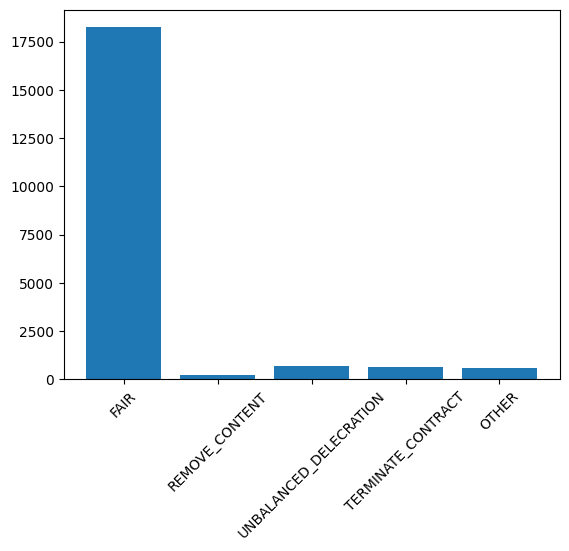

In [16]:
# count samples in each category
class_distribution = [cleaned_df[x].sum() for x in cleaned_df.columns if x not in ['text']]
plt.bar(class_name, class_distribution[0:5])
#roatate x label
plt.xticks(rotation=45)

## Convert to HuggingFace Dataset amd Handling class imbalancing

In [17]:
label_df = cleaned_df[['text','label']]
fair = label_df[label_df['label'] == 0]
unfair = label_df[label_df['label'] != 0]
unfair.reset_index(drop=True, inplace=True)
fair.reset_index(drop=True, inplace=True)

In [18]:
fair.shape, unfair.shape

((18235, 2), (2182, 2))

In [19]:
#import into huggingface dataset
TOS_features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=5, names=class_name)})
fair_ds= Dataset.from_pandas(fair,features=TOS_features)
unfair_ds= Dataset.from_pandas(unfair,features=TOS_features)
#balanced dataset using oversampling
dataset = interleave_datasets([fair_ds, unfair_ds], stopping_strategy="all_exhausted")
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 29176
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7294
    })
})

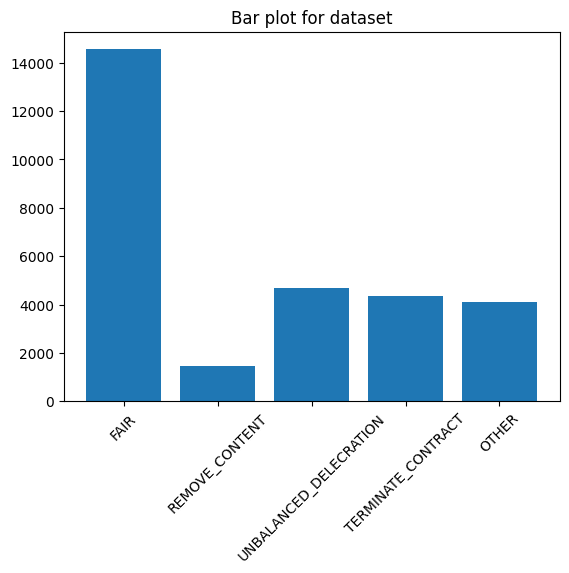

In [21]:
#plot bar plot for dataset['train']['label']
train_label = dataset['train']['label']
values = []
for i in range(5):
    values.append([x == i for x in train_label].count(True))
plt.bar(class_name,values)
plt.title('Bar plot for dataset')
plt.xticks(rotation=45)
plt.show()

sample count after balancing

In [22]:
pd.DataFrame({'class':class_name,'count':values})

,class,count
0,FAIR,14554
1,REMOVE_CONTENT,1454
2,UNBALANCED_DELECRATION,4703
3,TERMINATE_CONTRACT,4362
4,OTHER,4103


## Fine-Tune

convert from pandas dataframe into huggingface dataset library

auto tokenizer with gpt-2

In [23]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

def tokenize_function(examples):
  tokenizer.pad_token = tokenizer.eos_token
  return tokenizer(examples["text"], padding="max_length", truncation=True)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [24]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

train_set = tokenized_dataset['train']
test_set = tokenized_dataset['test']
smaller_train_set = train_set.shuffle(seed=42).select(range(1000))
smaller_test_set = test_set.shuffle(seed=42).select(range(200))


Map:   0%|          | 0/29176 [00:00<?, ? examples/s]

Map:   0%|          | 0/7294 [00:00<?, ? examples/s]

eveluating metrics (F1 and accuracy)

In [25]:
metric1 = evaluate.load("f1") #works better for imbalance dataset
metric2 = evaluate.load("accuracy") #general metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = metric1.compute(predictions=predictions,
                         references=labels,average='macro')['f1']
    accuracy = metric2.compute(predictions=predictions,
                               references=labels)['accuracy']
    return {"f1": f1, "accuracy": accuracy}

gpt-2 model with 5 classes

In [26]:
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=5)
training_args = TrainingArguments(output_dir="test_trainer")
model.config.pad_token_id = model.config.eos_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=4,learning_rate=5e-5,
                                  per_device_train_batch_size=4,
                                  gradient_accumulation_steps=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics,
)
trainer.train()
trainer.save_model(path+"gpt2_finetuned_5classes")

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.214800,0.291548,0.941162,0.945298
2,0.092600,0.123880,0.978671,0.978887
3,0.034800,0.116758,0.981996,0.982177
4,0.028900,0.130137,0.981324,0.981355


In [29]:
#save model
trainer.save_model("gpt2_finetuned_5classes")

plots

In [13]:
train_loss = [0.214800,0.092600,0.034800,0.028900]
valid_loss = [0.291548,0.123880,0.123880,0.130137]
test_f1 = [0.941162,0.978671,0.981996,0.981324]
test_acc = [0.945298,0.978887,0.982177,0.981355]


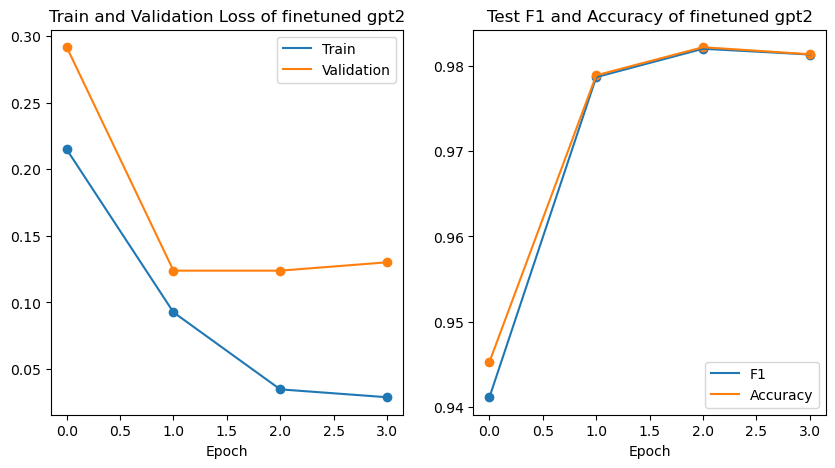

In [19]:
#subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_loss)
axs[0].plot(valid_loss)
axs[0].scatter(range(0,len(train_loss)),train_loss)
axs[0].scatter(range(0,len(valid_loss)),valid_loss)
axs[0].set_title('Train and Validation Loss of finetuned gpt2')
axs[0].set_label('Loss')
axs[0].set_xlabel('Epoch')
#legend
axs[0].legend(['Train', 'Validation'], loc='upper right')

axs[1].plot(test_f1)
axs[1].plot(test_acc)
axs[1].scatter(range(0,len(test_f1)),test_f1)
axs[1].scatter(range(0,len(test_acc)),test_acc)
axs[1].set_title('Test F1 and Accuracy of finetuned gpt2')
axs[1].set_label('F1 and Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['F1', 'Accuracy'], loc='best')

#save as svg
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.savefig('plot/gpt2_loss_f1_accuracy.svg', format='svg', dpi=1200)

gpt-2 model with 2-class (fair vs unfair)

In [ ]:
unfair_2class = unfair.copy()
unfair_2class['label'] = 1
fair_2class = fair.copy()
fair_2class['label'] = 0

fair_ds_2classes = Dataset.from_pandas(fair_2class)
unfair_ds_2classes = Dataset.from_pandas(unfair_2class)

#balanced dataset using oversampling
dataset_2classes = interleave_datasets([fair_ds_2classes, unfair_ds_2classes], stopping_strategy="all_exhausted")
dataset_2classes = dataset_2classes.train_test_split(test_size=0.2, shuffle=True, seed=42)

#tokenize
tokenized_dataset_2classes = dataset_2classes.map(tokenize_function, batched=True)

#split train vs test
train_set_2classes = tokenized_dataset_2classes['train']
test_set_2classes = tokenized_dataset_2classes['test']

# demo purpose
smaller_train_set_2classes = train_set_2classes.shuffle(seed=42).select(range(1000))
smaller_test_set_2classes = test_set_2classes.shuffle(seed=42).select(range(200))

Map:   0%|          | 0/29182 [00:00<?, ? examples/s]

Map:   0%|          | 0/7296 [00:00<?, ? examples/s]

In [ ]:
#gpt 2 model with 2 class
model_2classes = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model_2classes.config.pad_token_id = model_2classes.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_2classes  = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=3,learning_rate=5e-5,
                                  per_device_train_batch_size=4,
                                  gradient_accumulation_steps=2)

trainer_2classes = Trainer(
    model=model_2classes,
    args=training_args_2classes,
    train_dataset=train_set_2classes,
    eval_dataset=test_set_2classes,
    compute_metrics=compute_metrics,
)
trainer_2classes.train()
trainer_2classes.save_model(path+"gpt2_finetuned_2classes")

In [ ]:
trainer_2classes.evaluate(test_set_2classes)

{'eval_loss': 0.11723171174526215,
 'eval_f1': 0.9816240287837287,
 'eval_accuracy': 0.9816337719298246,
 'eval_runtime': 232.3045,
 'eval_samples_per_second': 31.407,
 'eval_steps_per_second': 3.926,
 'epoch': 3.0}

In [ ]:
trainer_2classes.save_model(path+"gpt2_finetuned_2classes")